In [336]:
# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.datasets import fetch_openml

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.base import clone
from sklearn.base import BaseEstimator

In [337]:
mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [338]:
X, y = mnist['data'], mnist['target']

In [339]:
X.shape

(70000, 784)

In [340]:
y.shape

(70000,)

In [341]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

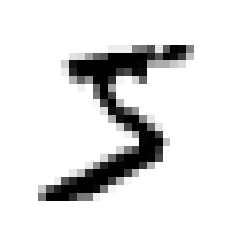

In [342]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [343]:
y.iloc[0]

'5'

In [344]:
y = y.astype(np.uint8)

In [345]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

In [346]:
# test on just one digit
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [347]:
# start with a Stocahstic Gradient Descent Classifier - efficient for large data sets
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [348]:
sgd_clf.predict([some_digit])

array([ True])

In [349]:
#skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [350]:
#for train_index, test_index in skfolds.split(X_train, y_train_5):
#    clone_clf = clone(sgd_clf)
#    X_train_folds = X_train.iloc[train_index]
#    y_train_folds = y_train_5.iloc[train_index]
#    X_test_folds = X_train.iloc[test_index]
#    y_train_folds = y_train_5.iloc[test_index]
    
    # for debug
#    print(X_train.iloc[train_index].shape)
#    print(y_train_5.iloc[train_index].shape)
#    print(y_train_folds.shape)
    
#    clone_clf.fit(X_train_folds, y_train_folds)
#    y_pred = clone_clf.predict(X_test_fold)
#    n_correct = sum(y_pred == y_test_fold)
#    print(n_correct / len(y_pred))

In [351]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9633 , 0.95695, 0.9146 ])

In [352]:
class  Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [353]:
# only about 10% of the data is  5, so always guessing 'not 5' gives ~90% accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [354]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [355]:
confusion_matrix(y_train_5, y_train_pred)

array([[52336,  2243],
       [ 1060,  4361]], dtype=int64)

In [356]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [357]:
# precision = accuracy of the positive predictions TP / (TP + FN)
# recall (sensitivity) = true positive rate

precision_score(y_train_5, y_train_pred) # when it claims an image is a 5, it is only correct 83.7% of the time

0.6603573591762568

In [358]:
recall_score(y_train_5, y_train_pred) # only detects 65% of the overall 5's

0.8044641210108836

In [359]:
# Since F1 score is the harminic mean of precision & recall, it will only be high if both precision AND recall are high
f1_score(y_train_5, y_train_pred)

0.7253222453222454

In [360]:
# since f1 gives more weight to low values, it also favors classifiers that have similar precision and recall
# which may not be what you want

# in the case of selecting movies that are safe for kids, 
# you would rather low recall (rejects some kid movies) 
# but high precision (vry sure of the ones it picks)

# on the other hand if your model picks out shoplifters from security camera footage,
# it would be okay to have low precison (gives lots of false alarms)
# but would want high recall so all shoplifters get caught

In [361]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([57392.7316778])

In [362]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [363]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [364]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [365]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [366]:
thresholds

array([-1240055.24095435, -1239461.43861287, -1238300.92282501, ...,
        1000939.19185372,  1024426.52263646,  1248437.63711962])

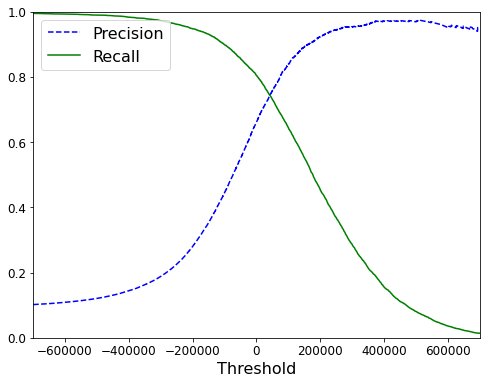

In [367]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [368]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

163633.3031519755

In [369]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [370]:
precision_score(y_train_5, y_train_pred_90)

0.9002517306482064

In [371]:
recall_score(y_train_5, y_train_pred_90)

0.5277624054602472

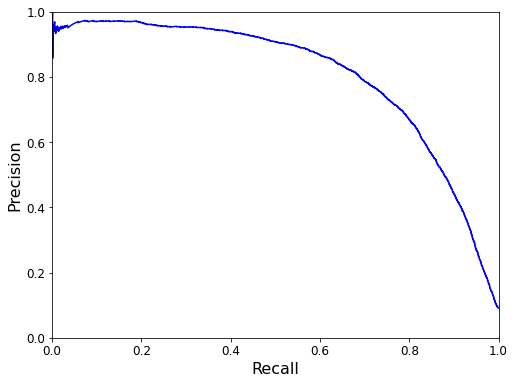

In [372]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [373]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

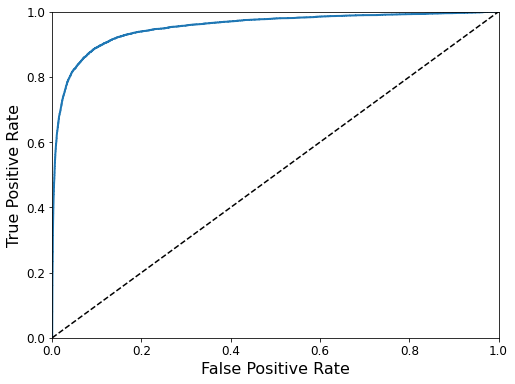

In [374]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [375]:
roc_auc_score(y_train_5, y_scores)

0.9536789698168869

In [376]:
forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [377]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

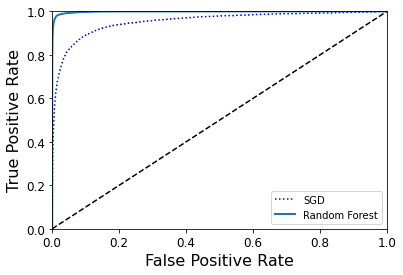

In [378]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [379]:
roc_auc_score(y_train_5, y_scores_forest)

0.99841182067052

In [380]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [381]:
print(f'precision: {precision_score(y_train_5, y_train_pred_forest)} - \
recall: {recall_score(y_train_5, y_train_pred_forest)} - \
F1: {f1_score(y_train_5, y_train_pred_forest)}')

precision: 0.9902933108250686 - recall: 0.8657074340527577 - F1: 0.9238188976377952


In [382]:
svm_clf = SVC()

In [383]:
svm_clf.fit(X_train, y_train)

SVC()

In [384]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [385]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [386]:
np.argmax(some_digit_scores)

5

In [387]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [388]:
svm_clf.classes_[5]

5

In [392]:
#ovr_clf = OneVsRestClassifier(SVC())

In [393]:
#ovr_clf.fit(X_train, y_train)

In [394]:
#ovr_clf.predict([some_digit])

In [395]:
#len(ovr_clf.estimators_)

In [396]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [397]:
sgd_clf.decision_function([some_digit])

array([[-473897.80801197, -644255.86485802, -347352.99430408,
         -30942.4528106 , -560971.15600433,  -42695.14872161,
        -495355.44702264, -327659.64997194, -485909.1798798 ,
        -495629.95766748]])

In [398]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8684 , 0.85975, 0.85475])

In [399]:
scaler = StandardScaler()

In [400]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [401]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.906  , 0.9074 , 0.91205])

In [402]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [403]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   26,    9,   11,   45,   42,    9,   41,    4],
       [   1, 6482,   42,   31,    7,   40,    6,    9,  112,   12],
       [  58,   41, 5293,  106,   90,   31,   93,   60,  169,   17],
       [  49,   40,  143, 5322,    4,  236,   37,   57,  150,   93],
       [  25,   25,   33,    9, 5359,    8,   54,   29,   95,  205],
       [  77,   44,   38,  180,   81, 4603,   99,   23,  183,   93],
       [  36,   31,   42,    2,   41,  102, 5617,    3,   44,    0],
       [  31,   26,   73,   34,   57,   14,    3, 5750,   19,  258],
       [  48,  164,   69,  139,   12,  160,   49,   21, 5054,  135],
       [  44,   35,   23,   89,  153,   39,    2,  186,   83, 5295]],
      dtype=int64)

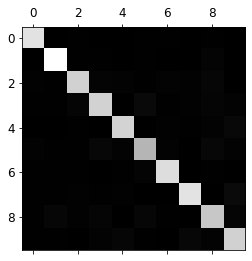

In [404]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [405]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

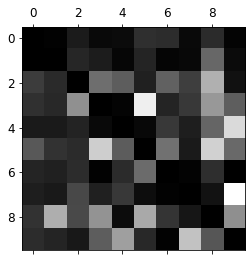

In [406]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [407]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
        images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

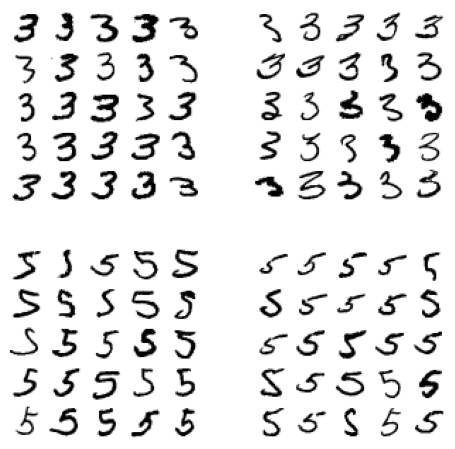

In [408]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [409]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [410]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [411]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [412]:
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_predict, average='macro')

0.976410265560605

In [413]:
f1_score(y_multilabel, y_train_knn_predict, average='weighted')

0.9778357403921755

In [418]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

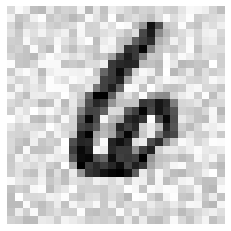

In [422]:
some_mod_digit = X_train_mod.iloc[155]
some_mod_image = some_mod_digit.values.reshape(28, 28)

plt.imshow(some_mod_image, cmap='binary')
plt.axis('off')
plt.show()

In [427]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [432]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

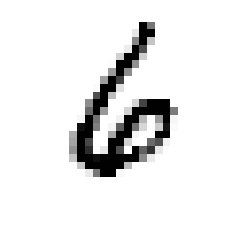

In [438]:
clean_digit = knn_clf.predict([some_mod_digit])
plot_digit(clean_digit)